## Evaluating Object Detection Models
- Interception over Union
- Non Maximum Suppression

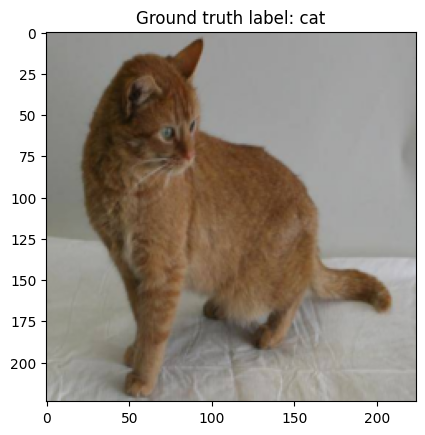

In [1]:
# loading helpful libraries
 
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

torch.manual_seed(6)    # random seed for reproducibility

""" What we need:
        1. Transformations for our images
        2. Dataset (structured this way):
            |__dog-vs-cat
                        |__ dog (folder with dog images)
                        |__ cat (folder with cat images) 
        3. Dataloader 
""" 
# transformations for our images
trainformers = transforms.Compose([
    transforms.PILToTensor(),       # image pixel range [0, 255]
    transforms.Resize((224, 224)),   
])

# loading out dataset
train_dataset = ImageFolder(
    root='./datasets/dogs-vs-cats/train',
    transform=trainformers,
)

# creating train dataloader
trainloader = DataLoader(
    dataset=train_dataset,
    batch_size=1,
    shuffle=True,
)

# now, we can inspect an image in out dataset (or dataloader)
sample_image, image_label = next(iter(trainloader))     # dimension: [batch_size, channels #, image height, image width]
sample_image.squeeze_(0)    # remove the batch_size = 1
# swap the channels number with the image (height) width position
this_image = sample_image.permute(1, 2, 0)      # dimension: [image height, image width, channels #]
plt.imshow(this_image)
plt.title(
    f'Ground truth label: {train_dataset.classes[image_label]}'
)
plt.show() 

### Drawing Sample Bounding Boxes

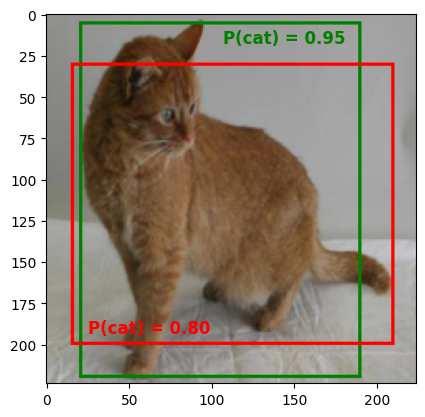

In [2]:
# drawing (arbituray) bounding boxes on our image above
from torchvision.utils import draw_bounding_boxes

# x_min, y_min, x_max, y_max
box1 = [20, 5, 190, 220]   # green box
box2 = [15, 30, 210, 200]   # red box
bounding_box_tensor = torch.tensor([box1, box2])

# adding the bounding box tensor on our sample image (above)
draw_boxes = draw_bounding_boxes(
    image=sample_image,
    boxes=bounding_box_tensor,
    width=2,
    colors=['green', 'red'],
)

# convert the image to PIL image for visualization
img_transformer = transforms.ToPILImage()
sample_boxed_image = img_transformer(draw_boxes)

plt.imshow(sample_boxed_image)
# lets add arbituary objectness scores
plt.text(107, 17, "P(cat) = 0.95", color="green", fontsize="large", fontweight="bold")
plt.text(25, 193, "P(cat) = 0.80", color="red", fontsize="large", fontweight="bold")
plt.show()


### Intersection over Union

In [3]:
from torchvision.ops import box_iou
from numpy import round 

# our bounding boxes: x_min, y_min, x_max, y_max
box1 = [20, 5, 190, 220]   # green box
box2 = [15, 30, 210, 200]   # red box

iou_score = box_iou(
    torch.tensor(box1).unsqueeze(0),     # convert boxes from list to tensors
    torch.tensor(box2).unsqueeze(0)
)

print(
    f'IoU score = {round(iou_score.item(), 2)}'
)
# score = 0.71 (approximately) 

IoU score = 0.71


### Non-Maximum Suppression

In [4]:
from torchvision.ops import nms 

# our bounding boxes and scores tensors
box1 = [20, 5, 190, 220]   # green box with score 0.95
box2 = [15, 30, 210, 200]   # red box with score 0.80
bounding_box_tensor = torch.tensor([box1, box2]).float()
scores_tensor = torch.tensor([0.95, 0.80])

choose_box_idx = nms(
    boxes=bounding_box_tensor,
    scores=scores_tensor,
    iou_threshold=0.70
)

keep_box = bounding_box_tensor[choose_box_idx]
print(
    f'Best bounding box: {keep_box}'
)
# we keep the green box :D

Best bounding box: tensor([[ 20.,   5., 190., 220.]])


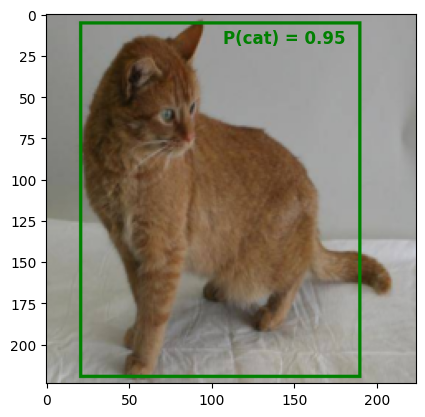

In [8]:
bestbox = torch.tensor(box1).unsqueeze_(0)

draw_bestbox = draw_bounding_boxes(
    image=sample_image,
    boxes=bestbox,
    width=2,
    colors='green'
)

image = img_transformer(draw_bestbox)

plt.imshow(image)
plt.text(
    107, 17, "P(cat) = 0.95", color="green", fontsize="large", fontweight="bold"
)
plt.show()